# Capacity analysis

## Introduction

Demo of the Capacity analysis.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
# %autoreload?

In [2]:
import datetime as dt
from openenergyid.capacity import CapacityInput, CapacityAnalysis
from openenergyid.capacity.models import CapacityOutput, PeakDetail
from openenergyid.models import TimeSeries


# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## read in the sample data

In [3]:
with open("data/capacity/power_sample.json", "r") as f:
    input_data = CapacityInput.model_validate_json(f.read())

input_data.series.to_pandas(input_data.timezone)

2024-05-31 00:15:00+02:00    0.332
2024-05-31 00:30:00+02:00    0.292
2024-05-31 00:45:00+02:00    0.316
2024-05-31 01:00:00+02:00    0.316
2024-05-31 01:15:00+02:00    0.328
                             ...  
2024-07-02 22:45:00+02:00    1.184
2024-07-02 23:00:00+02:00    1.112
2024-07-02 23:15:00+02:00    1.056
2024-07-02 23:30:00+02:00    0.772
2024-07-02 23:45:00+02:00    0.732
Length: 3167, dtype: float64

## Analysis

First we make the analysis object
then run our functions find_peaks() and peaks_with_surroundings()
then export it to an output file

we also show an example of visualization for the analysis

In [4]:
# %load_ext snakeviz

In [5]:
analysis = CapacityAnalysis(
    data=input_data.series.to_pandas(timezone=input_data.timezone), threshold=0
)
peaks = analysis.find_peaks()
display(peaks)

2024-05-31 19:15:00+02:00    2.320
2024-06-13 17:30:00+02:00    3.596
2024-07-02 11:00:00+02:00    2.852
dtype: float64

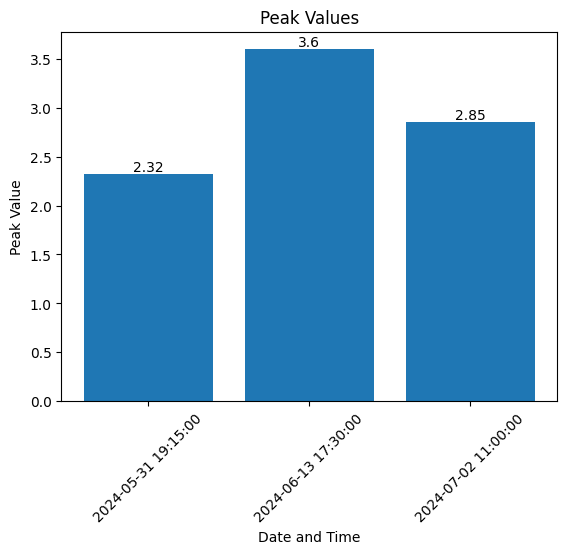

In [6]:
# Convert the index to a nicely formatted string representation
peaks.index = peaks.index.strftime("%Y-%m-%d %H:%M:%S")  # type: ignore

# Plot the dataframe
bars = plt.bar(peaks.index, peaks)
plt.xlabel("Date and Time")
plt.ylabel("Peak Value")
plt.title("Peak Values")
plt.xticks(rotation=45)

# Adding the values to the top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha="center", va="bottom")

plt.show()

## Peak moments


## Sliding frame analysis
![Pasted image 20240628161500.png](<attachment:Pasted image 20240628161500.png>)
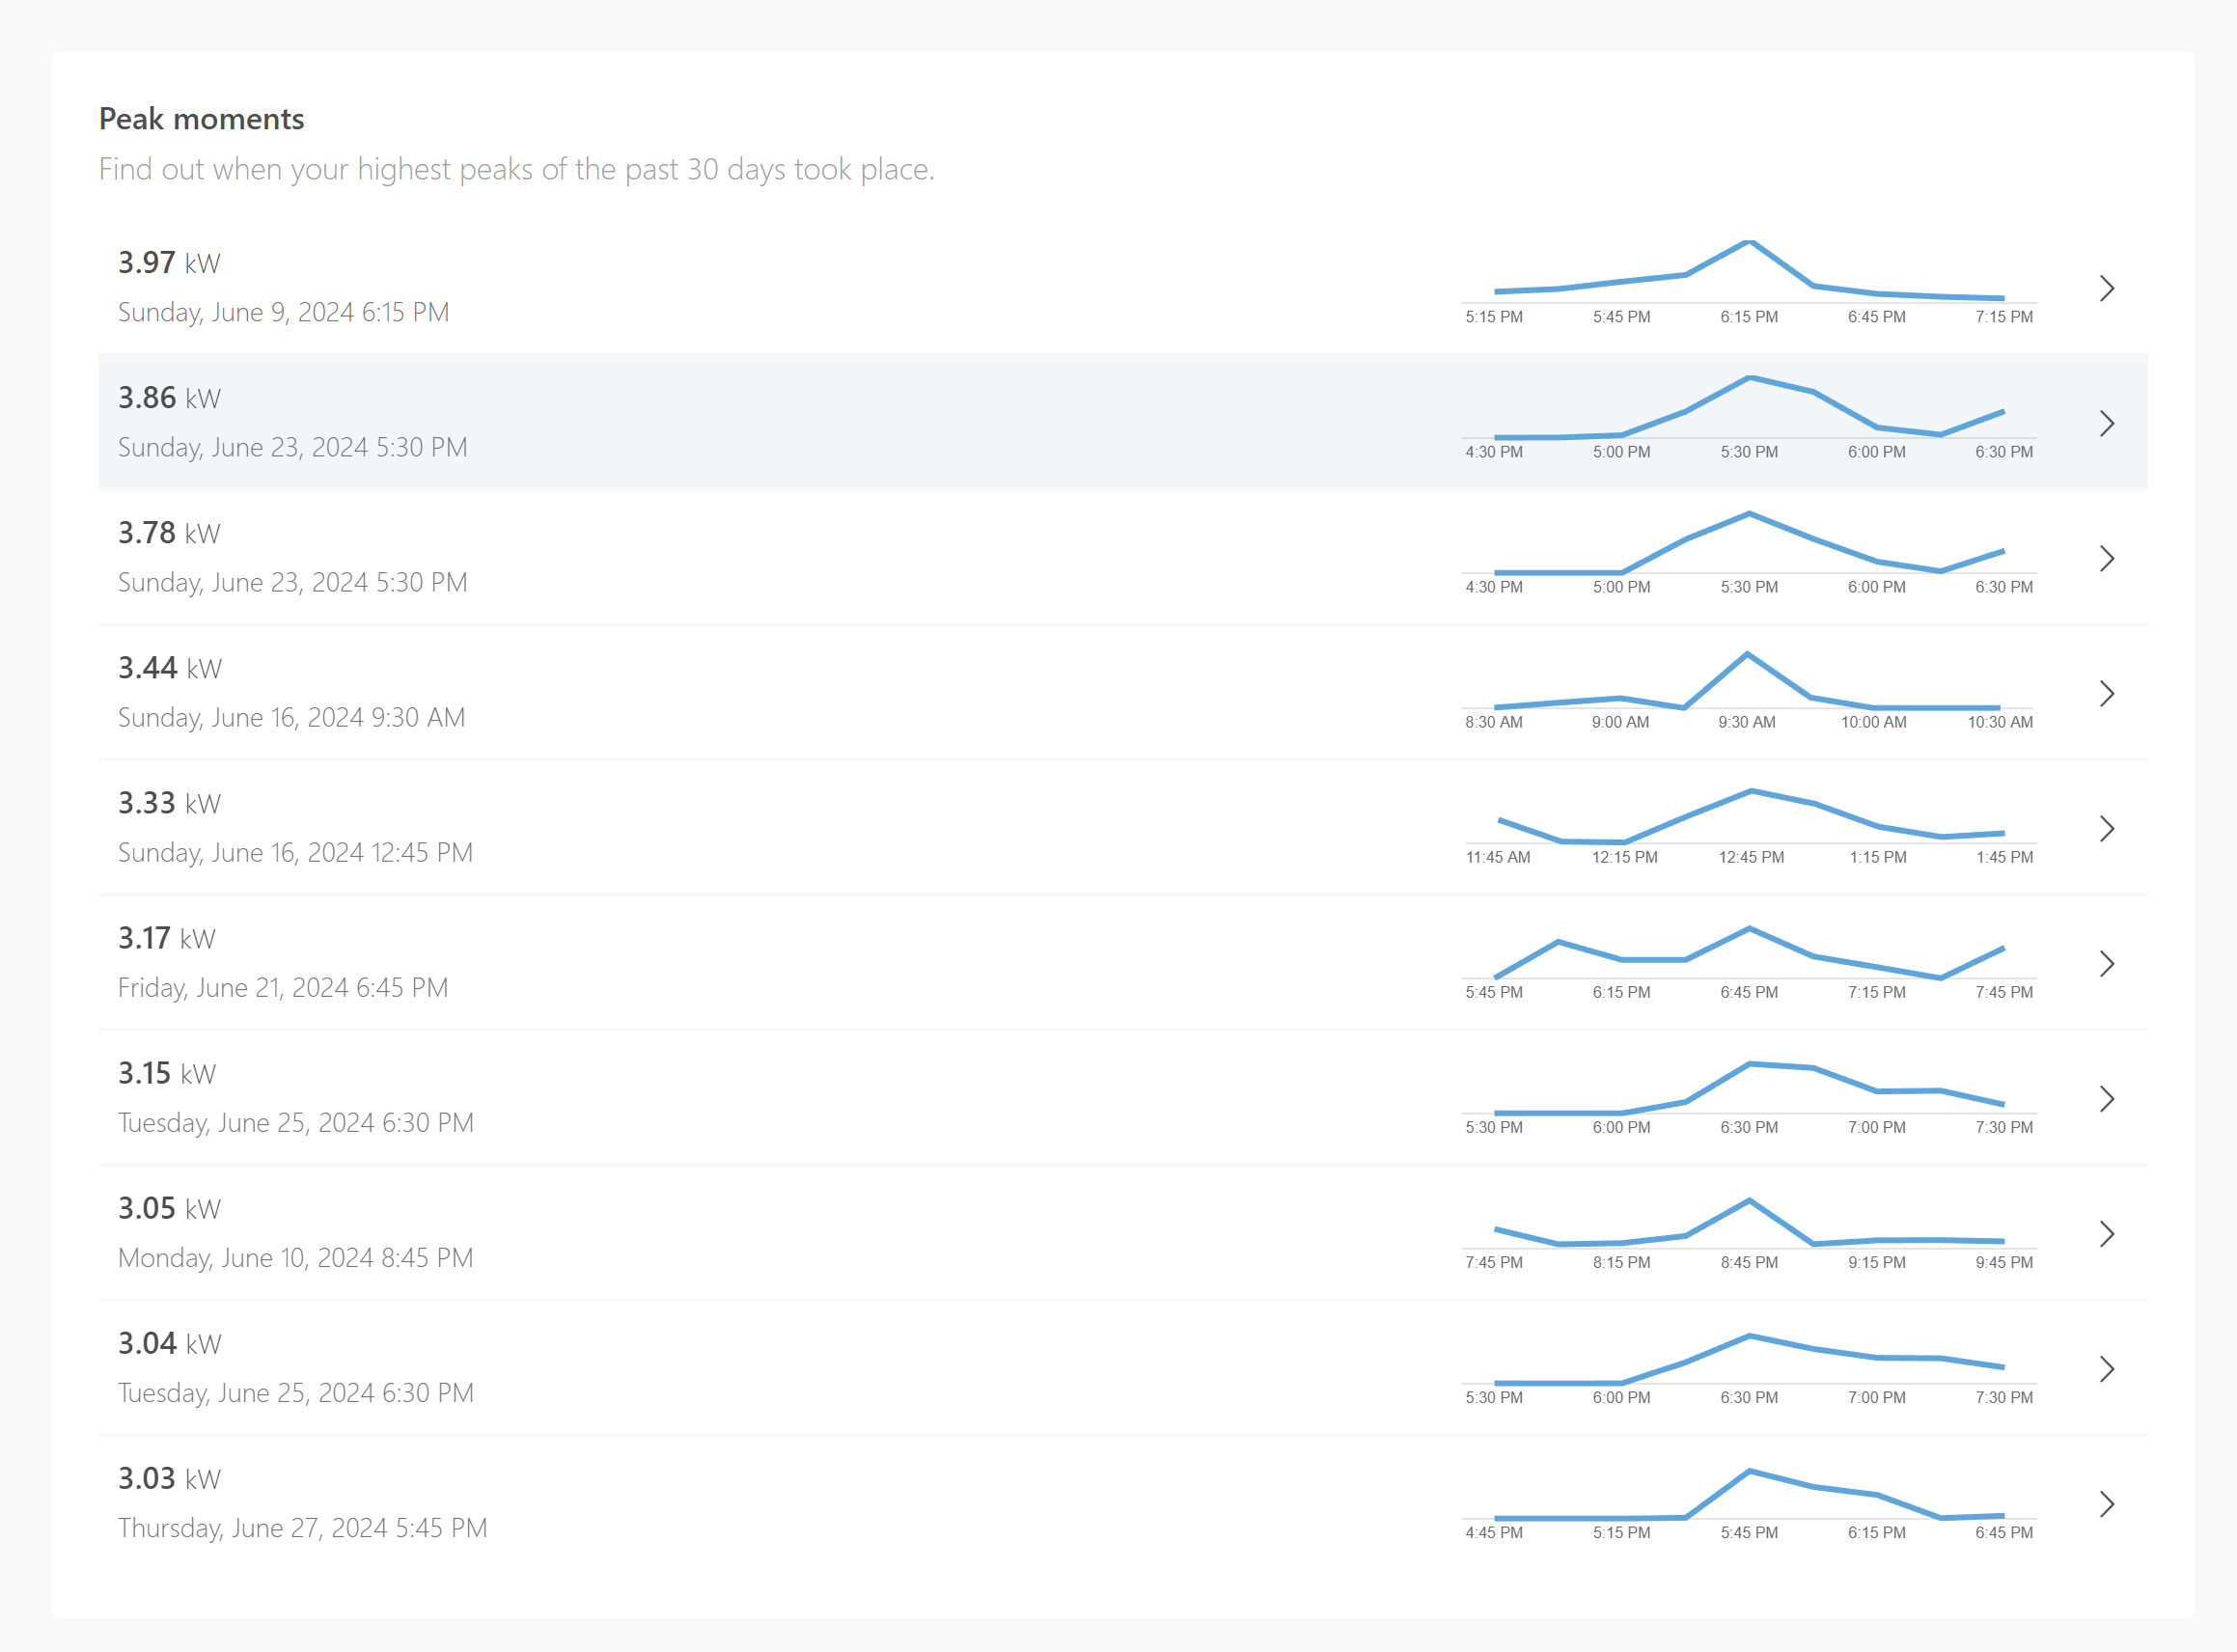

In [7]:
data = analysis.find_peaks_with_surroundings()
display(data)

[[Timestamp('2024-06-13 17:30:00+0200', tz='Europe/Brussels'),
  3.596,
  2024-06-13 16:30:00+02:00    2.104
  2024-06-13 16:45:00+02:00    0.900
  2024-06-13 17:00:00+02:00    2.628
  2024-06-13 17:15:00+02:00    1.352
  2024-06-13 17:30:00+02:00    3.596
  2024-06-13 17:45:00+02:00    3.316
  2024-06-13 18:00:00+02:00    2.216
  2024-06-13 18:15:00+02:00    1.412
  2024-06-13 18:30:00+02:00    0.768
  2024-06-13 18:45:00+02:00    0.544
  dtype: float64],
 [Timestamp('2024-06-24 18:00:00+0200', tz='Europe/Brussels'),
  3.048,
  2024-06-24 17:00:00+02:00    0.628
  2024-06-24 17:15:00+02:00    0.724
  2024-06-24 17:30:00+02:00    2.492
  2024-06-24 17:45:00+02:00    1.720
  2024-06-24 18:00:00+02:00    3.048
  2024-06-24 18:15:00+02:00    1.208
  2024-06-24 18:30:00+02:00    0.584
  2024-06-24 18:45:00+02:00    0.416
  2024-06-24 19:00:00+02:00    0.472
  2024-06-24 19:15:00+02:00    0.560
  dtype: float64],
 [Timestamp('2024-06-06 00:15:00+0200', tz='Europe/Brussels'),
  2.888,
  2024

In [8]:
# save output as our CapacityOutput object
output = CapacityOutput(
    peaks=TimeSeries.from_pandas(analysis.find_peaks()),
    peak_details=[  # type: ignore
        PeakDetail(
            peak_time=peak_time,  # type: ignore
            peak_value=peak_value,  # type: ignore
            surrounding_data=TimeSeries.from_pandas(surrounding_data),  # type: ignore
        )
        for peak_time, peak_value, surrounding_data in analysis.find_peaks_with_surroundings()
    ],
)

# save the CapacityOutput object to a file
with open("data/capacity/capacity_output.json", "w") as f:
    f.write(output.model_dump_json(indent=4))

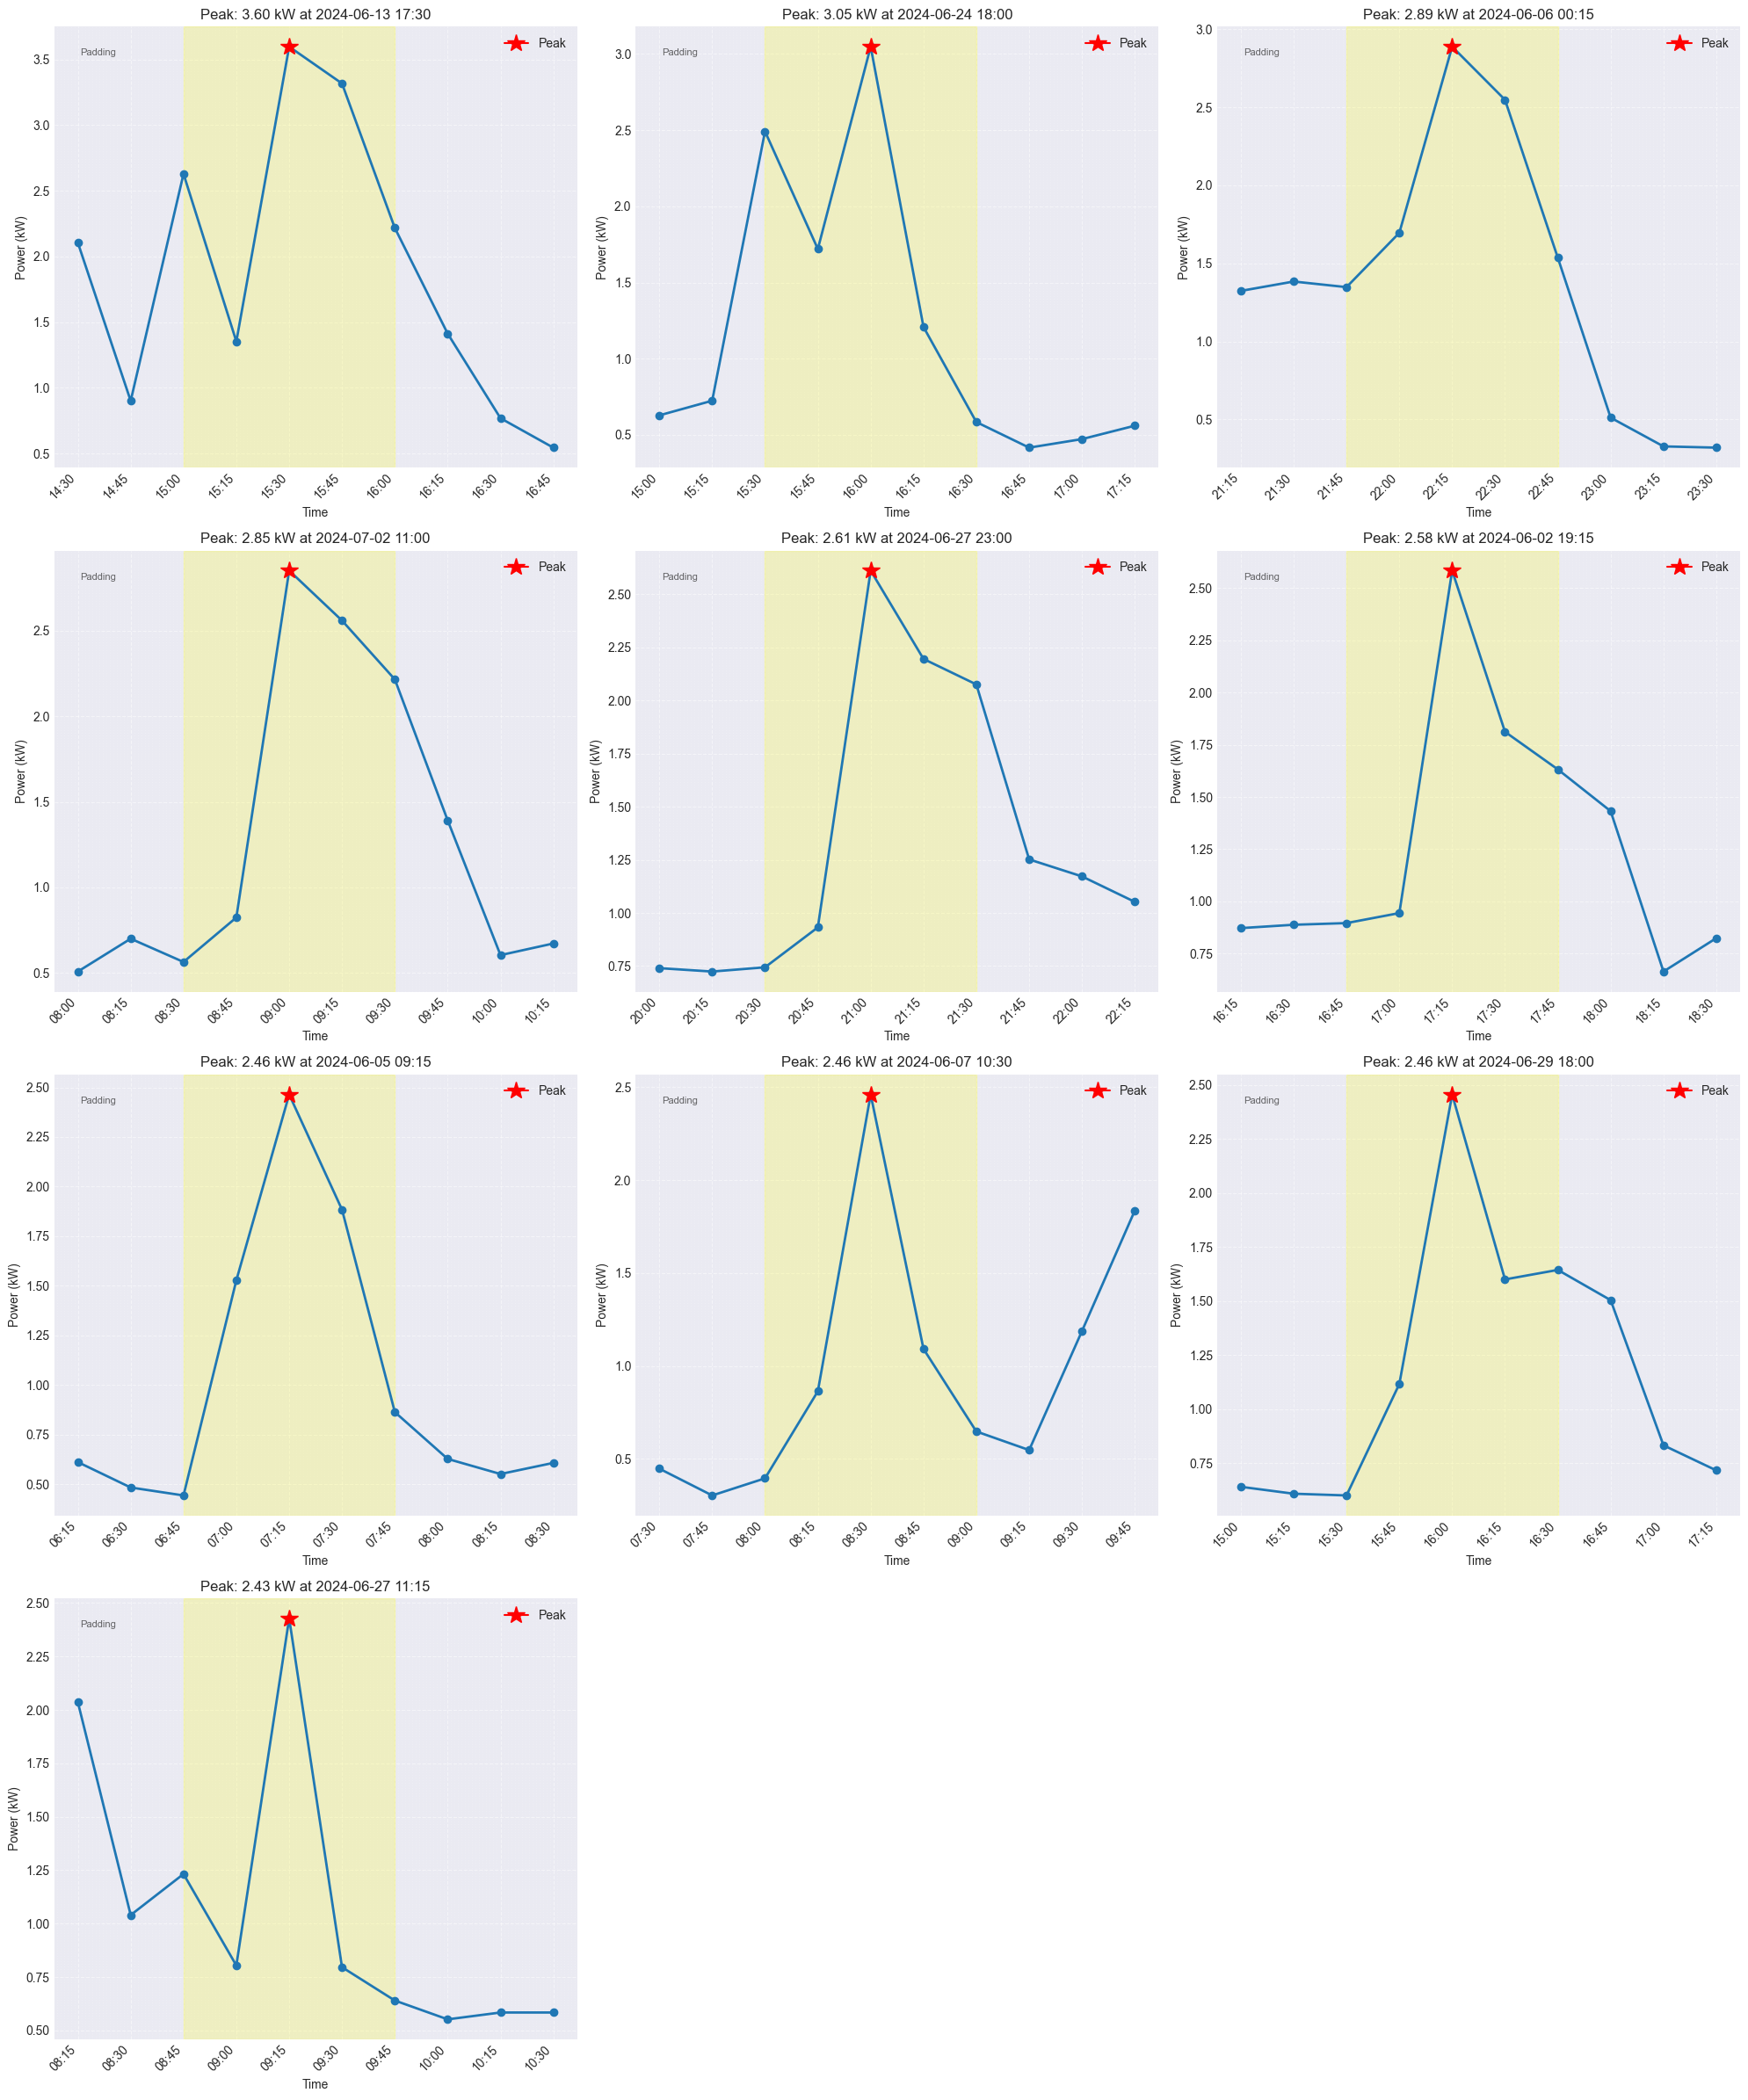

In [9]:
def plot_peaks(data):
    # Set up the plot style
    plt.style.use("seaborn-v0_8-dark")

    fig, axs = plt.subplots(4, 3, figsize=(20, 24))
    # fig.suptitle('Power Consumption Peaks', fontsize=16)

    axs = axs.flatten()

    for i, (peak_time, peak_value, surrounding_data) in enumerate(data):
        timestamps = surrounding_data.index
        values = surrounding_data.values

        ax = axs[i]
        ax.plot(timestamps, values, marker="o", linestyle="-", linewidth=2, markersize=6)
        ax.plot(peak_time, peak_value, marker="*", color="red", markersize=15, label="Peak")

        ax.set_title(f"Peak: {peak_value:.2f} kW at {peak_time.strftime('%Y-%m-%d %H:%M')}")
        ax.set_ylabel("Power (kW)")
        ax.set_xlabel("Time")

        # Set major locator for 15-minute intervals
        ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 15, 30, 45]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

        # Set minor locator for every minute
        ax.xaxis.set_minor_locator(mdates.MinuteLocator())

        # Customize grid
        ax.grid(True, which="major", linestyle="--", alpha=0.5)
        ax.grid(True, which="minor", linestyle=":", alpha=0.2)

        # Rotate and align the tick labels
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

        # Add legend
        ax.legend()

        # Highlight the padding area
        padding_minutes = 30  # Assuming 2 hours of padding (4 * 15 minutes on each side)
        start_padding = peak_time - dt.timedelta(minutes=padding_minutes)
        end_padding = peak_time + dt.timedelta(minutes=padding_minutes)
        ax.axvspan(start_padding, end_padding, color="yellow", alpha=0.2)

        # Add text to indicate padding
        ax.text(
            0.05,
            0.95,
            "Padding",
            transform=ax.transAxes,
            verticalalignment="top",
            fontsize=8,
            alpha=0.7,
        )

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


# Assume the data is stored in a variable called 'data'


# Call the function to create the plots
plot_peaks(data)

# Polars edition

In [10]:
import polars as pl
import json
import typing


## Read in data

In [11]:
# whats the best file(type) to pass?
# currently we receive this json from server so try it using this
# read the json file in using json.load into a lazyframe
def read_in(path: str) -> pl.LazyFrame:
    with open(path, "r") as f:
        data = json.load(f)
        timezone_info = data["timeZone"]
    lf = pl.LazyFrame({"timestamp": data["series"]["index"], "value": data["series"]["data"]})
    lf = lf.with_columns(pl.col("timestamp").cast(pl.Datetime).dt.convert_time_zone(timezone_info))
    return lf

## Validate

In [12]:
lf = read_in("data/capacity/power_sample.json")
df = lf.collect()
df.collect_schema()

Schema([('timestamp', Datetime(time_unit='us', time_zone='Europe/Brussels')),
        ('value', Float64)])

## Analysis


Main part, we try to recreate the functionality using more performant polars API here.

In [13]:
def find_peaks(data: pl.LazyFrame, threshold: float = 0, amount: int = 10) -> pl.LazyFrame:
    peaks = data.filter(pl.col("value") > threshold).sort(by="value", descending=True).head(amount)
    return peaks


def find_temporal_relative_peaks(
    df: pl.LazyFrame, amount: int = 10, threshold: float = 0, x_padding: int = 4
) -> typing.List[typing.Tuple[dt.datetime, float]]:
    window_size = dt.timedelta(minutes=15 * (2 * x_padding + 1))

    peaks = (
        df.filter(pl.col("value") > threshold)
        .sort("value", descending=True)
        .limit(amount * 2)
        .with_columns(
            [
                pl.col("timestamp").dt.offset_by(f"-{15 * x_padding}m").alias("start_time"),
                pl.col("timestamp").dt.offset_by(f"{15 * x_padding}m").alias("end_time"),
            ]
        )
        .collect()
    )

    result = []
    for peak in peaks.iter_rows(named=True):
        if not any(abs(peak["timestamp"] - prev_peak[0]) < window_size for prev_peak in result):
            result.append((peak["timestamp"], peak["value"]))
            if len(result) == amount:
                break

    return result

## Timing and checking performance of the bears

In [14]:
%%timeit
lf = read_in("data/capacity/power_sample.json")
peaks = find_peaks(lf, threshold=0, amount=10).collect()
temporal_peaks = find_temporal_relative_peaks(lf, amount=10, threshold=0, x_padding=4)

3.08 ms ± 111 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%%timeit
with open("data/capacity/power_sample.json", "r") as f:
    input_data = CapacityInput.model_validate_json(f.read())

analysis = CapacityAnalysis(
    data=input_data.series.to_pandas(timezone=input_data.timezone), threshold=0
)
peaks = analysis.find_peaks()
data = analysis.find_peaks_with_surroundings()

23.4 ms ± 224 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
# %%snakeviz -t
lf = read_in("data/capacity/power_sample.json")
peaks = find_peaks(lf, threshold=0, amount=10).collect()
temporal_peaks = find_temporal_relative_peaks(lf, amount=10, threshold=0, x_padding=4)
display(temporal_peaks)

[(datetime.datetime(2024, 6, 13, 19, 30, tzinfo=zoneinfo.ZoneInfo(key='Europe/Brussels')),
  3.596),
 (datetime.datetime(2024, 6, 24, 20, 0, tzinfo=zoneinfo.ZoneInfo(key='Europe/Brussels')),
  3.048),
 (datetime.datetime(2024, 6, 6, 2, 15, tzinfo=zoneinfo.ZoneInfo(key='Europe/Brussels')),
  2.888),
 (datetime.datetime(2024, 7, 2, 13, 0, tzinfo=zoneinfo.ZoneInfo(key='Europe/Brussels')),
  2.852),
 (datetime.datetime(2024, 6, 28, 1, 0, tzinfo=zoneinfo.ZoneInfo(key='Europe/Brussels')),
  2.612),
 (datetime.datetime(2024, 6, 2, 21, 15, tzinfo=zoneinfo.ZoneInfo(key='Europe/Brussels')),
  2.584),
 (datetime.datetime(2024, 6, 5, 11, 15, tzinfo=zoneinfo.ZoneInfo(key='Europe/Brussels')),
  2.464),
 (datetime.datetime(2024, 6, 7, 12, 30, tzinfo=zoneinfo.ZoneInfo(key='Europe/Brussels')),
  2.46),
 (datetime.datetime(2024, 6, 29, 20, 0, tzinfo=zoneinfo.ZoneInfo(key='Europe/Brussels')),
  2.456),
 (datetime.datetime(2024, 6, 27, 13, 15, tzinfo=zoneinfo.ZoneInfo(key='Europe/Brussels')),
  2.428)]

In [17]:
import pandas as pd
from pytz import timezone

lf = read_in("data/capacity/power_sample.json")
temporal_peaks = find_temporal_relative_peaks(lf, amount=10, threshold=0, x_padding=4)

# Convert the timestamps to the Europe/Brussels timezone
brussels_tz = timezone("Europe/Brussels")
temporal_peaks = [(timestamp.astimezone(brussels_tz), value) for timestamp, value in temporal_peaks]

display(
    str(temporal_peaks[0][0].strftime("%Y-%m-%d %H:%M:%S"))
    + " date at Power: "
    + str(temporal_peaks[0][1])
)

test = pd.DataFrame(temporal_peaks, columns=["timestamp", "value"])
display(test)

'2024-06-13 19:30:00 date at Power: 3.596'

,timestamp,value
0,2024-06-13 19:30:00+02:00,3.596
1,2024-06-24 20:00:00+02:00,3.048
2,2024-06-06 02:15:00+02:00,2.888
3,2024-07-02 13:00:00+02:00,2.852
4,2024-06-28 01:00:00+02:00,2.612
5,2024-06-02 21:15:00+02:00,2.584
6,2024-06-05 11:15:00+02:00,2.464
7,2024-06-07 12:30:00+02:00,2.460
8,2024-06-29 20:00:00+02:00,2.456
9,2024-06-27 13:15:00+02:00,2.428


### comparing the timings(on my machine)

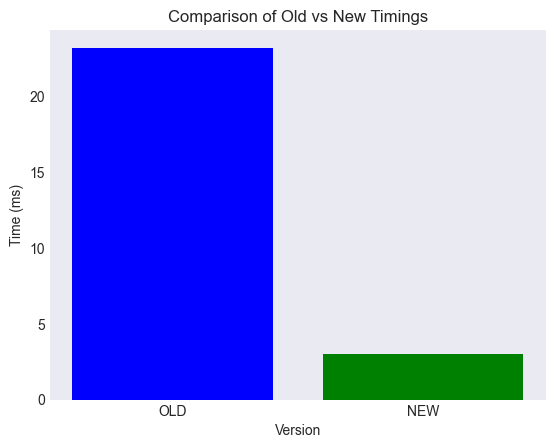

In [18]:
import matplotlib.pyplot as plt

# Define the old and new timings
old_timing = 23.2
new_timing = 3

# Define the labels and values for the bar chart
labels = ["OLD", "NEW"]
values = [old_timing, new_timing]

# Create the bar chart
plt.bar(labels, values, color=["blue", "green"])

# Label the axes and add a title
plt.xlabel("Version")
plt.ylabel("Time (ms)")
plt.title("Comparison of Old vs New Timings")

# Show the plot
plt.show()

## Some other testing happens here.
not interesting for main analysis

In [19]:
def find_peaks_with_surroundings(
    lf: pl.LazyFrame, num_peaks: int = 10, threshold: float = 0, window_minutes: int = 15
) -> pl.LazyFrame:
    peaks = find_peaks(lf, threshold, amount=num_peaks)
    display(peaks.collect())
    # excellent function that should be cherished, but the logic seems te be easier just in regular python.
    peaks_rolled = (
        peaks.sort(by="timestamp")
        .rolling(
            period=dt.timedelta(minutes=window_minutes), index_column="timestamp", closed="right"
        )
        .agg(
            [
                pl.col("timestamp", "value").sort_by("value").last().name.prefix("peak_"),
                # pl.col("timestamp", "value").get(pl.col("value").arg_max()).name.prefix("peak_"),
                pl.all(),
            ]
        )
        # .unique(subset=["peak_timestamp"])
        # .sort("peak_value", descending=True)
    )
    return peaks_rolled

In [20]:
lf = read_in("data/capacity/power_sample.json")
# find peaks
# display(find_peaks(data=lf,threshold=2.5, amount=20).collect())
display(
    find_peaks_with_surroundings(lf, window_minutes=60, num_peaks=100)
    .sort(by="peak_value", descending=True)
    .collect()
)

timestamp,value
"datetime[μs, Europe/Brussels]",f64
2024-06-13 19:30:00 CEST,3.596
2024-06-13 19:45:00 CEST,3.316
2024-06-24 20:00:00 CEST,3.048
2024-06-06 02:15:00 CEST,2.888
2024-07-02 13:00:00 CEST,2.852
…,…
2024-06-27 12:45:00 CEST,1.232
2024-07-02 23:45:00 CEST,1.22
2024-06-27 03:45:00 CEST,1.212


timestamp,peak_timestamp,peak_value,value
"datetime[μs, Europe/Brussels]","datetime[μs, Europe/Brussels]",f64,list[f64]
2024-06-13 19:30:00 CEST,2024-06-13 19:30:00 CEST,3.596,"[2.628, 1.352, 3.596]"
2024-06-13 19:45:00 CEST,2024-06-13 19:30:00 CEST,3.596,"[2.628, 1.352, … 3.316]"
2024-06-13 20:00:00 CEST,2024-06-13 19:30:00 CEST,3.596,"[1.352, 3.596, … 2.216]"
2024-06-13 20:15:00 CEST,2024-06-13 19:30:00 CEST,3.596,"[3.596, 3.316, … 1.412]"
2024-06-24 20:00:00 CEST,2024-06-24 20:00:00 CEST,3.048,"[2.492, 1.72, 3.048]"
…,…,…,…
2024-07-02 01:15:00 CEST,2024-07-02 01:15:00 CEST,1.264,[1.264]
2024-07-02 01:30:00 CEST,2024-07-02 01:15:00 CEST,1.264,"[1.264, 1.208]"
2024-06-03 15:00:00 CEST,2024-06-03 15:00:00 CEST,1.256,[1.256]


In [21]:
# df.write_parquet("data/capacity/power_sample.parquet") # write the sample file as parquet
lf_parquet_scan = pl.scan_parquet("data/capacity/power_sample.parquet")
parquet_schema = lf_parquet_scan.collect_schema()
display(parquet_schema)
lf = read_in("data/capacity/power_sample.json")
display(lf.collect_schema())
display(f"The results are the same: {parquet_schema == lf.collect_schema()}")

Schema([('id', String),
        ('timeZone', String),
        ('series', Struct({'index': List(String), 'data': List(Float64)}))])

Schema([('timestamp', Datetime(time_unit='us', time_zone='Europe/Brussels')),
        ('value', Float64)])

'The results are the same: False'

### INFO: [Parquet file](https://parquet.apache.org/)
.parquet the smallest file size and loading or writing Parquet files is lightning fast as the layout of data in a Polars DataFrame in memory mirrors the layout of a Parquet file on disk in many respects. wellknown and widespread.

Unlike CSV, Parquet is a columnar format. This means that the data is stored in columns rather than rows. This is a more efficient way of storing data as it allows for better compression and faster access to data.
### INFO: Lazy vs Eager
[docs](https://docs.pola.rs/user-guide/concepts/lazy-vs-eager/) explain that lazy optimises everything.

casting types to the colomns

In [22]:
# lf = (
#     pl.scan_parquet("data/capacity/power_sample.parquet")
#     .with_columns(pl.col("series.index").cast(pl.Datetime))
# )
# lf.collect()

### testing analysis


In [23]:
lf = pl.scan_parquet("data/capacity/power_sample.parquet")
# what is read in?
display(lf.collect_schema())
# Change data types
# drop the id column
lf = lf.drop("id")
display(lf.collect_schema())
# extract the series struct to lazyframe
# lf = lf.with_columns(pl.col("series.index").cast(pl.Datetime)).collect()

Schema([('id', String),
        ('timeZone', String),
        ('series', Struct({'index': List(String), 'data': List(Float64)}))])

Schema([('timeZone', String),
        ('series', Struct({'index': List(String), 'data': List(Float64)}))])